In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [2]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_3144\2419121426.py:2: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv("C:\\Users\\ADMIN\Project\\.venv\\Sleep testFiltered_EEG_Data1.csv")


In [3]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [4]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [5]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


In [6]:

def get_segments(labels):
    """Return list of (start_idx, end_idx, label) for continuous segments"""
    segments = []
    start = 0
    current_label = labels[0]

    for i in range(1, len(labels)):
        if labels[i] != current_label:
            segments.append((start, i, current_label))
            start = i
            current_label = labels[i]

    segments.append((start, len(labels), current_label))
    return segments
segments = get_segments(labels)

valid_segments = [seg for seg in segments if (seg[1] - seg[0]) >= 256]
seg_df = pd.DataFrame(valid_segments, columns=['start', 'end', 'Annotation'])
seg_df["length"] = seg_df["end"] - seg_df["start"]






In [20]:
seg_df_n3 = seg_df[seg_df['Annotation'] == ' Sleep stage N3']

seg_df_R = seg_df[seg_df['Annotation'] == ' Sleep stage R']

seg_df_W = seg_df[seg_df['Annotation'] == ' Sleep stage W']

seg_df_N1 = seg_df[seg_df['Annotation'] == ' Sleep stage N1']

seg_df_N2 = seg_df[seg_df['Annotation'] == ' Sleep stage N2']

seg_counts = seg_df['Annotation'].value_counts()
print(seg_counts)


Annotation
Sleep stage N1    36
Sleep stage N2    33
Sleep stage W     14
Sleep stage N3     8
Sleep stage R      8
Name: count, dtype: int64


In [21]:
print(seg_df_n3)

      start      end       Annotation  length
15   806400   821760   Sleep stage N3   15360
17   829440   844800   Sleep stage N3   15360
19   852480   898560   Sleep stage N3   46080
21   906240   921600   Sleep stage N3   15360
23   929280   936960   Sleep stage N3    7680
64  3571200  3609600   Sleep stage N3   38400
76  4945920  4976640   Sleep stage N3   30720
78  4984320  4992000   Sleep stage N3    7680


In [10]:
print(seg_df_R)

      start      end      Annotation  length
31  1190400  1328640   Sleep stage R  138240
33  1336320  1382400   Sleep stage R   46080
49  2403840  2411520   Sleep stage R    7680
51  2419200  2426880   Sleep stage R    7680
70  3978240  4193280   Sleep stage R  215040
72  4200960  4416000   Sleep stage R  215040
83  5299200  5306880   Sleep stage R    7680
85  5345280  5790720   Sleep stage R  445440


In [11]:
print(seg_df_W)

      start      end      Annotation  length
0         0    61440   Sleep stage W   61440
6    199680   207360   Sleep stage W    7680
10   268800   299520   Sleep stage W   30720
34  1382400  1474560   Sleep stage W   92160
40  1896960  1904640   Sleep stage W    7680
53  2434560  3079680   Sleep stage W  645120
55  3087360  3095040   Sleep stage W    7680
57  3102720  3118080   Sleep stage W   15360
73  4416000  4454400   Sleep stage W   38400
80  5007360  5030400   Sleep stage W   23040
87  5798400  5806080   Sleep stage W    7680
93  5959680  5967360   Sleep stage W    7680
95  5982720  6120960   Sleep stage W  138240
98  6481920  6558720   Sleep stage W   76800


In [12]:
print(seg_df_N1)

      start      end       Annotation  length
1     61440   122880   Sleep stage N1   61440
3    130560   138240   Sleep stage N1    7680
5    184320   199680   Sleep stage N1   15360
7    207360   253440   Sleep stage N1   46080
9    261120   268800   Sleep stage N1    7680
11   299520   391680   Sleep stage N1   92160
13   629760   637440   Sleep stage N1    7680
25  1075200  1082880   Sleep stage N1    7680
27  1136640  1144320   Sleep stage N1    7680
29  1175040  1182720   Sleep stage N1    7680
32  1328640  1336320   Sleep stage N1    7680
35  1474560  1520640   Sleep stage N1   46080
37  1551360  1566720   Sleep stage N1   15360
39  1843200  1896960   Sleep stage N1   53760
41  1904640  1943040   Sleep stage N1   38400
43  2127360  2135040   Sleep stage N1    7680
45  2211840  2219520   Sleep stage N1    7680
47  2304000  2311680   Sleep stage N1    7680
52  2426880  2434560   Sleep stage N1    7680
54  3079680  3087360   Sleep stage N1    7680
56  3095040  3102720   Sleep stage

In [14]:
print(seg_df_N2)

      start      end       Annotation  length
2    122880   130560   Sleep stage N2    7680
4    138240   184320   Sleep stage N2   46080
8    253440   261120   Sleep stage N2    7680
12   391680   629760   Sleep stage N2  238080
14   637440   806400   Sleep stage N2  168960
16   821760   829440   Sleep stage N2    7680
18   844800   852480   Sleep stage N2    7680
20   898560   906240   Sleep stage N2    7680
22   921600   929280   Sleep stage N2    7680
24   936960  1075200   Sleep stage N2  138240
26  1082880  1136640   Sleep stage N2   53760
28  1144320  1175040   Sleep stage N2   30720
30  1182720  1190400   Sleep stage N2    7680
36  1520640  1551360   Sleep stage N2   30720
38  1566720  1843200   Sleep stage N2  276480
42  1943040  2127360   Sleep stage N2  184320
44  2135040  2211840   Sleep stage N2   76800
46  2219520  2304000   Sleep stage N2   84480
48  2311680  2403840   Sleep stage N2   92160
50  2411520  2419200   Sleep stage N2    7680
59  3179520  3287040   Sleep stage

## EEG C4-M1

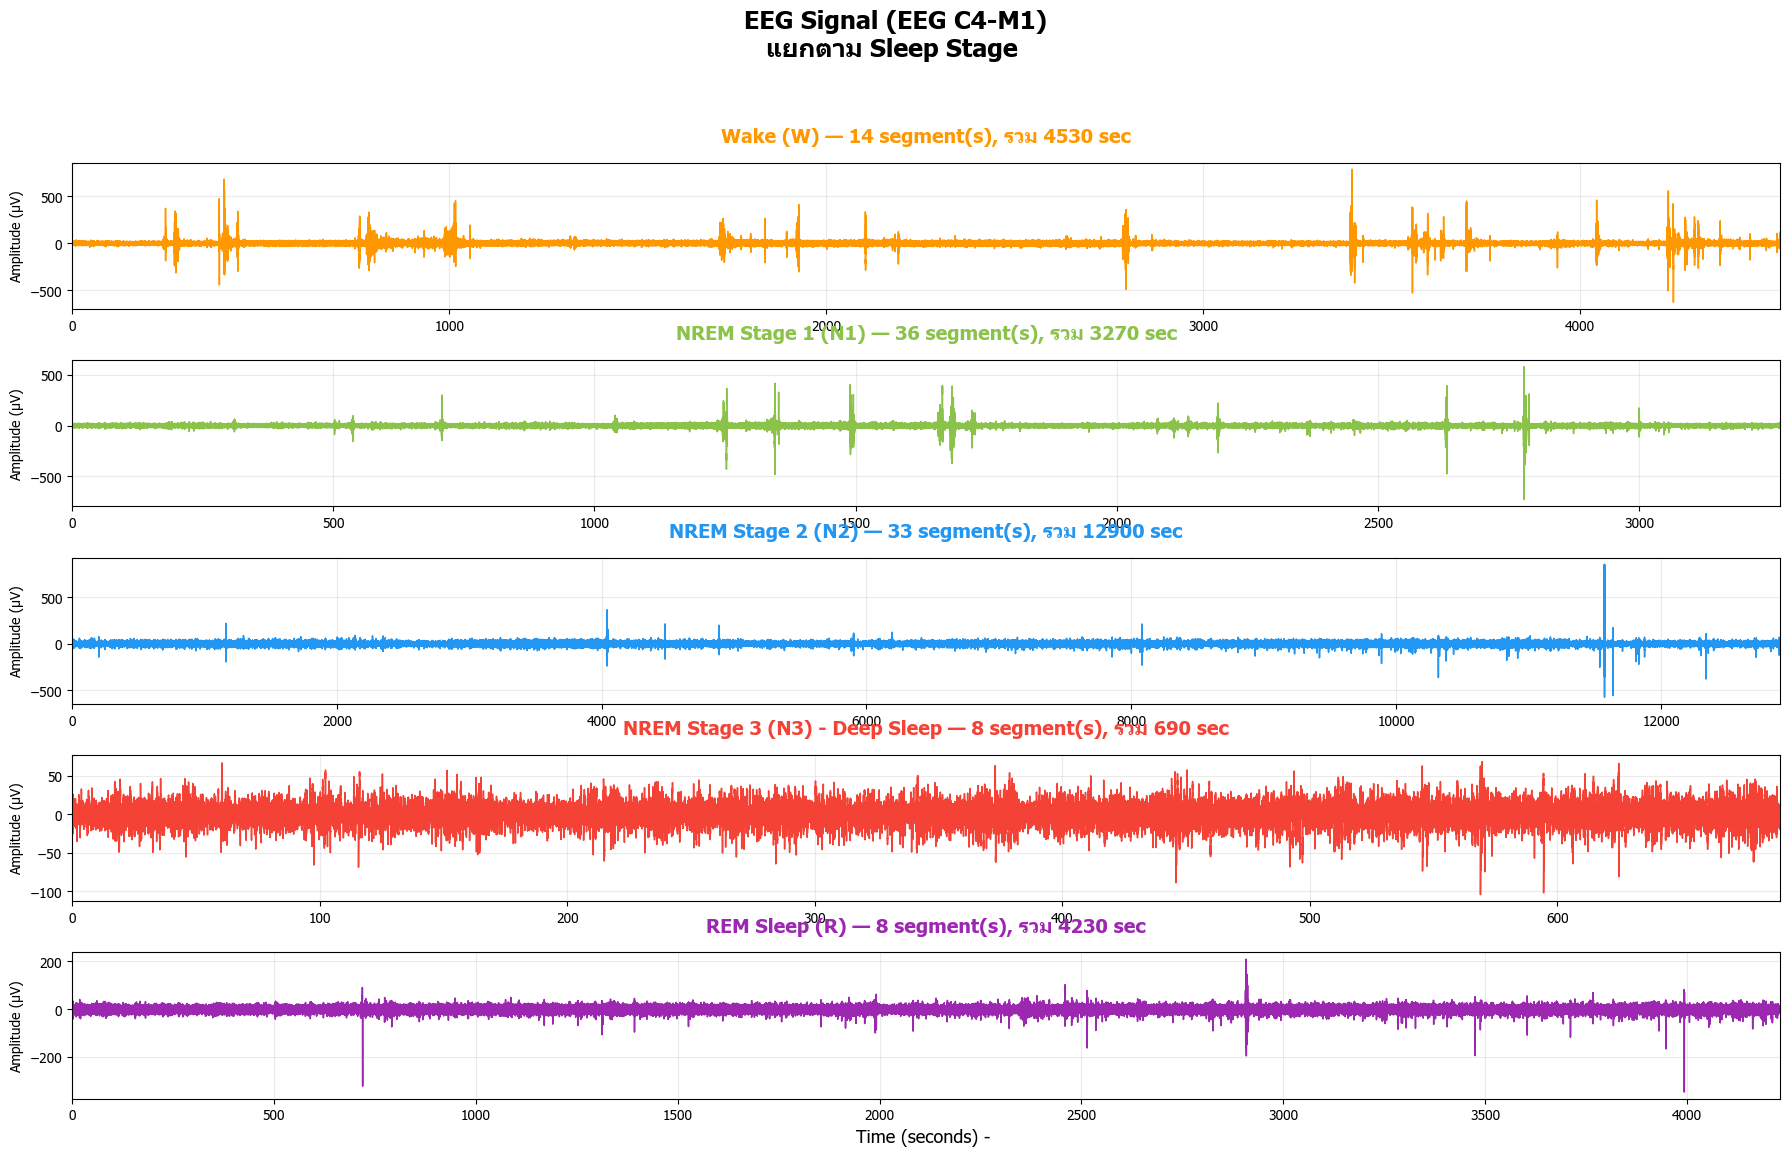

In [22]:

# ตั้งค่า font ภาษาไทย (ถ้าไม่มี ให้ติดตั้งก่อน: pip install font-thai)
plt.rcParams['font.family'] = 'Tahoma'  # หรือ 'Cordia New', 'Angsana New'

# ช่องที่ต้องการ plot
eeg_channel = 'EEG C4-M1'  # เปลี่ยนเป็น F4-M1 ก็ได้

# สีมาตรฐาน
stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

stage_dfs = {
    ' Sleep stage W': seg_df_W,
    ' Sleep stage N1': seg_df_N1,
    ' Sleep stage N2': seg_df_N2,
    ' Sleep stage N3': seg_df_n3,
    ' Sleep stage R': seg_df_R
}

fig, axes = plt.subplots(5, 1, figsize=(18, 12))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage ',
             fontsize=18, fontweight='bold', y=0.96)

for idx, (stage, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    segs = stage_dfs[stage]
    total_time = 0.0
    all_signals = []
    all_times = []

    for _, row in segs.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal))
        
        all_signals.extend(signal)
        all_times.extend(time_axis)
        
        total_time += duration  # ต่อชิดทันที ไม่มี gap

    if len(all_signals) > 0:
        ax.plot(all_times, all_signals, color=color, linewidth=1.1)
    
    seg_count = len(segs)
    ax.set_title(f"{stage_titles[stage]} — {seg_count} segment(s), รวม {total_time:.0f} sec",
                 fontsize=14, fontweight='bold', color=color, pad=15)
    ax.set_ylabel('Amplitude (µV)')
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)

    if len(all_signals) == 0:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes,
                ha='center', va='center', fontsize=16, color='gray')

axes[-1].set_xlabel('Time (seconds) - ', fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(hspace=0.35)
plt.show()

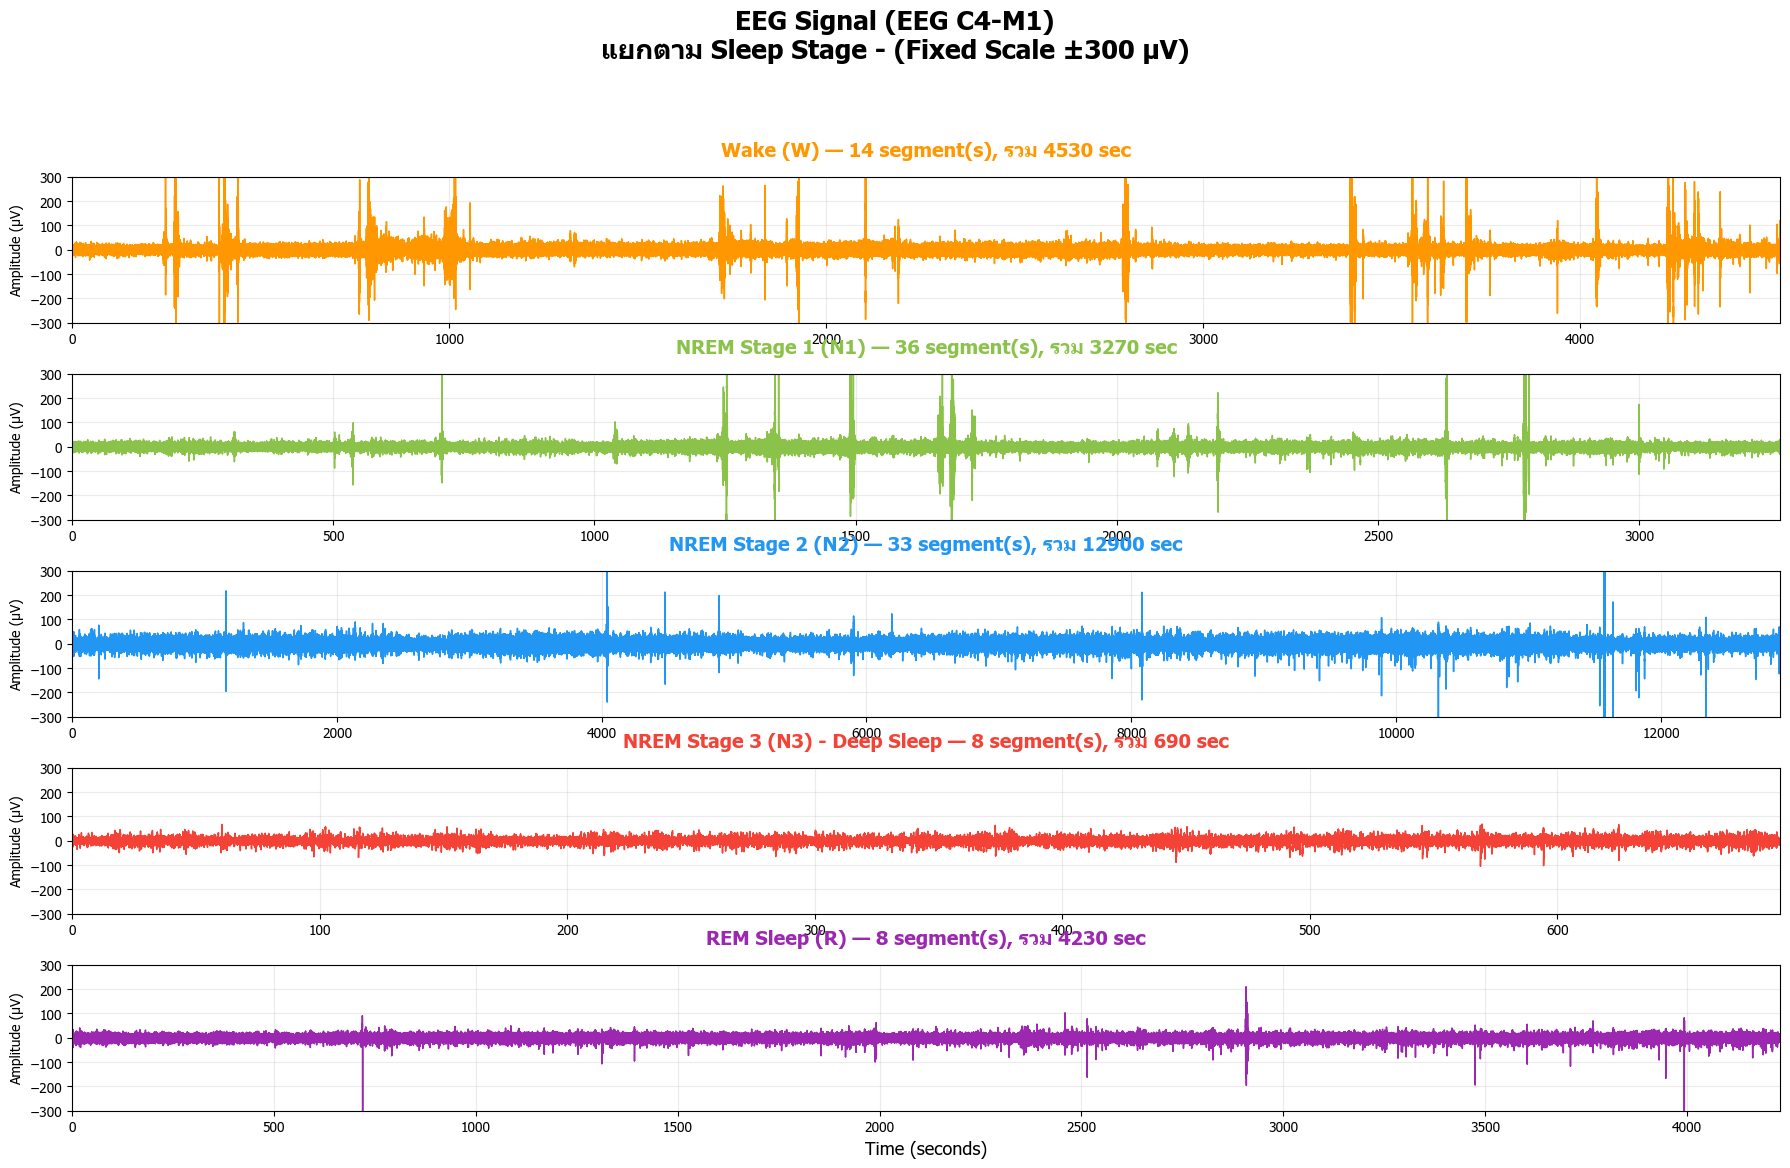

In [23]:

# ช่อง EEG ที่ต้องการ plot
eeg_channel = 'EEG C4-M1'   # หรือ 'EEG F4-M1' ก็ได้

# สำคัญมาก: ต้องมี { } เพื่อเป็น dictionary
stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

# รวม seg_df ของแต่ละ stage
stage_dfs = {
    ' Sleep stage W': seg_df_W,
    ' Sleep stage N1': seg_df_N1,
    ' Sleep stage N2': seg_df_N2,
    ' Sleep stage N3': seg_df_n3,
    ' Sleep stage R':  seg_df_R
}

# ตั้งค่า font ภาษาไทย (ถ้าไม่มีให้ใช้ 'Tahoma' หรือไม่ใส่ก็ได้)
plt.rcParams['font.family'] = 'Tahoma'

# เริ่มวาดกราฟ
fig, axes = plt.subplots(5, 1, figsize=(18, 12))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage - (Fixed Scale ±300 µV)',
             fontsize=19, fontweight='bold', y=0.97)

for idx, (stage, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    segs = stage_dfs[stage]
    total_time = 0.0
    all_signals = []
    all_times = []

    for _, row in segs.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal), endpoint=False)
        
        all_signals.extend(signal)
        all_times.extend(time_axis)
        total_time += duration

    if len(all_signals) > 0:
        ax.plot(all_times, all_signals, color=color, linewidth=1.1)
    
    seg_count = len(segs)
    ax.set_title(f"{stage_titles[stage]} — {seg_count} segment(s), รวม {total_time:.0f} sec",
                 fontsize=14, fontweight='bold', color=color, pad=15)
    ax.set_ylabel('Amplitude (µV)')
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)
    
    # Fixed scale ทุกกราฟ ±300 µV
    ax.set_ylim(-300, 300)
    ax.set_yticks([-300, -200, -100, 0, 100, 200, 300])

    if len(all_signals) == 0:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes,
                ha='center', va='center', fontsize=16, color='gray')

axes[-1].set_xlabel('Time (seconds)', fontsize=13)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.subplots_adjust(hspace=0.35)
plt.show()

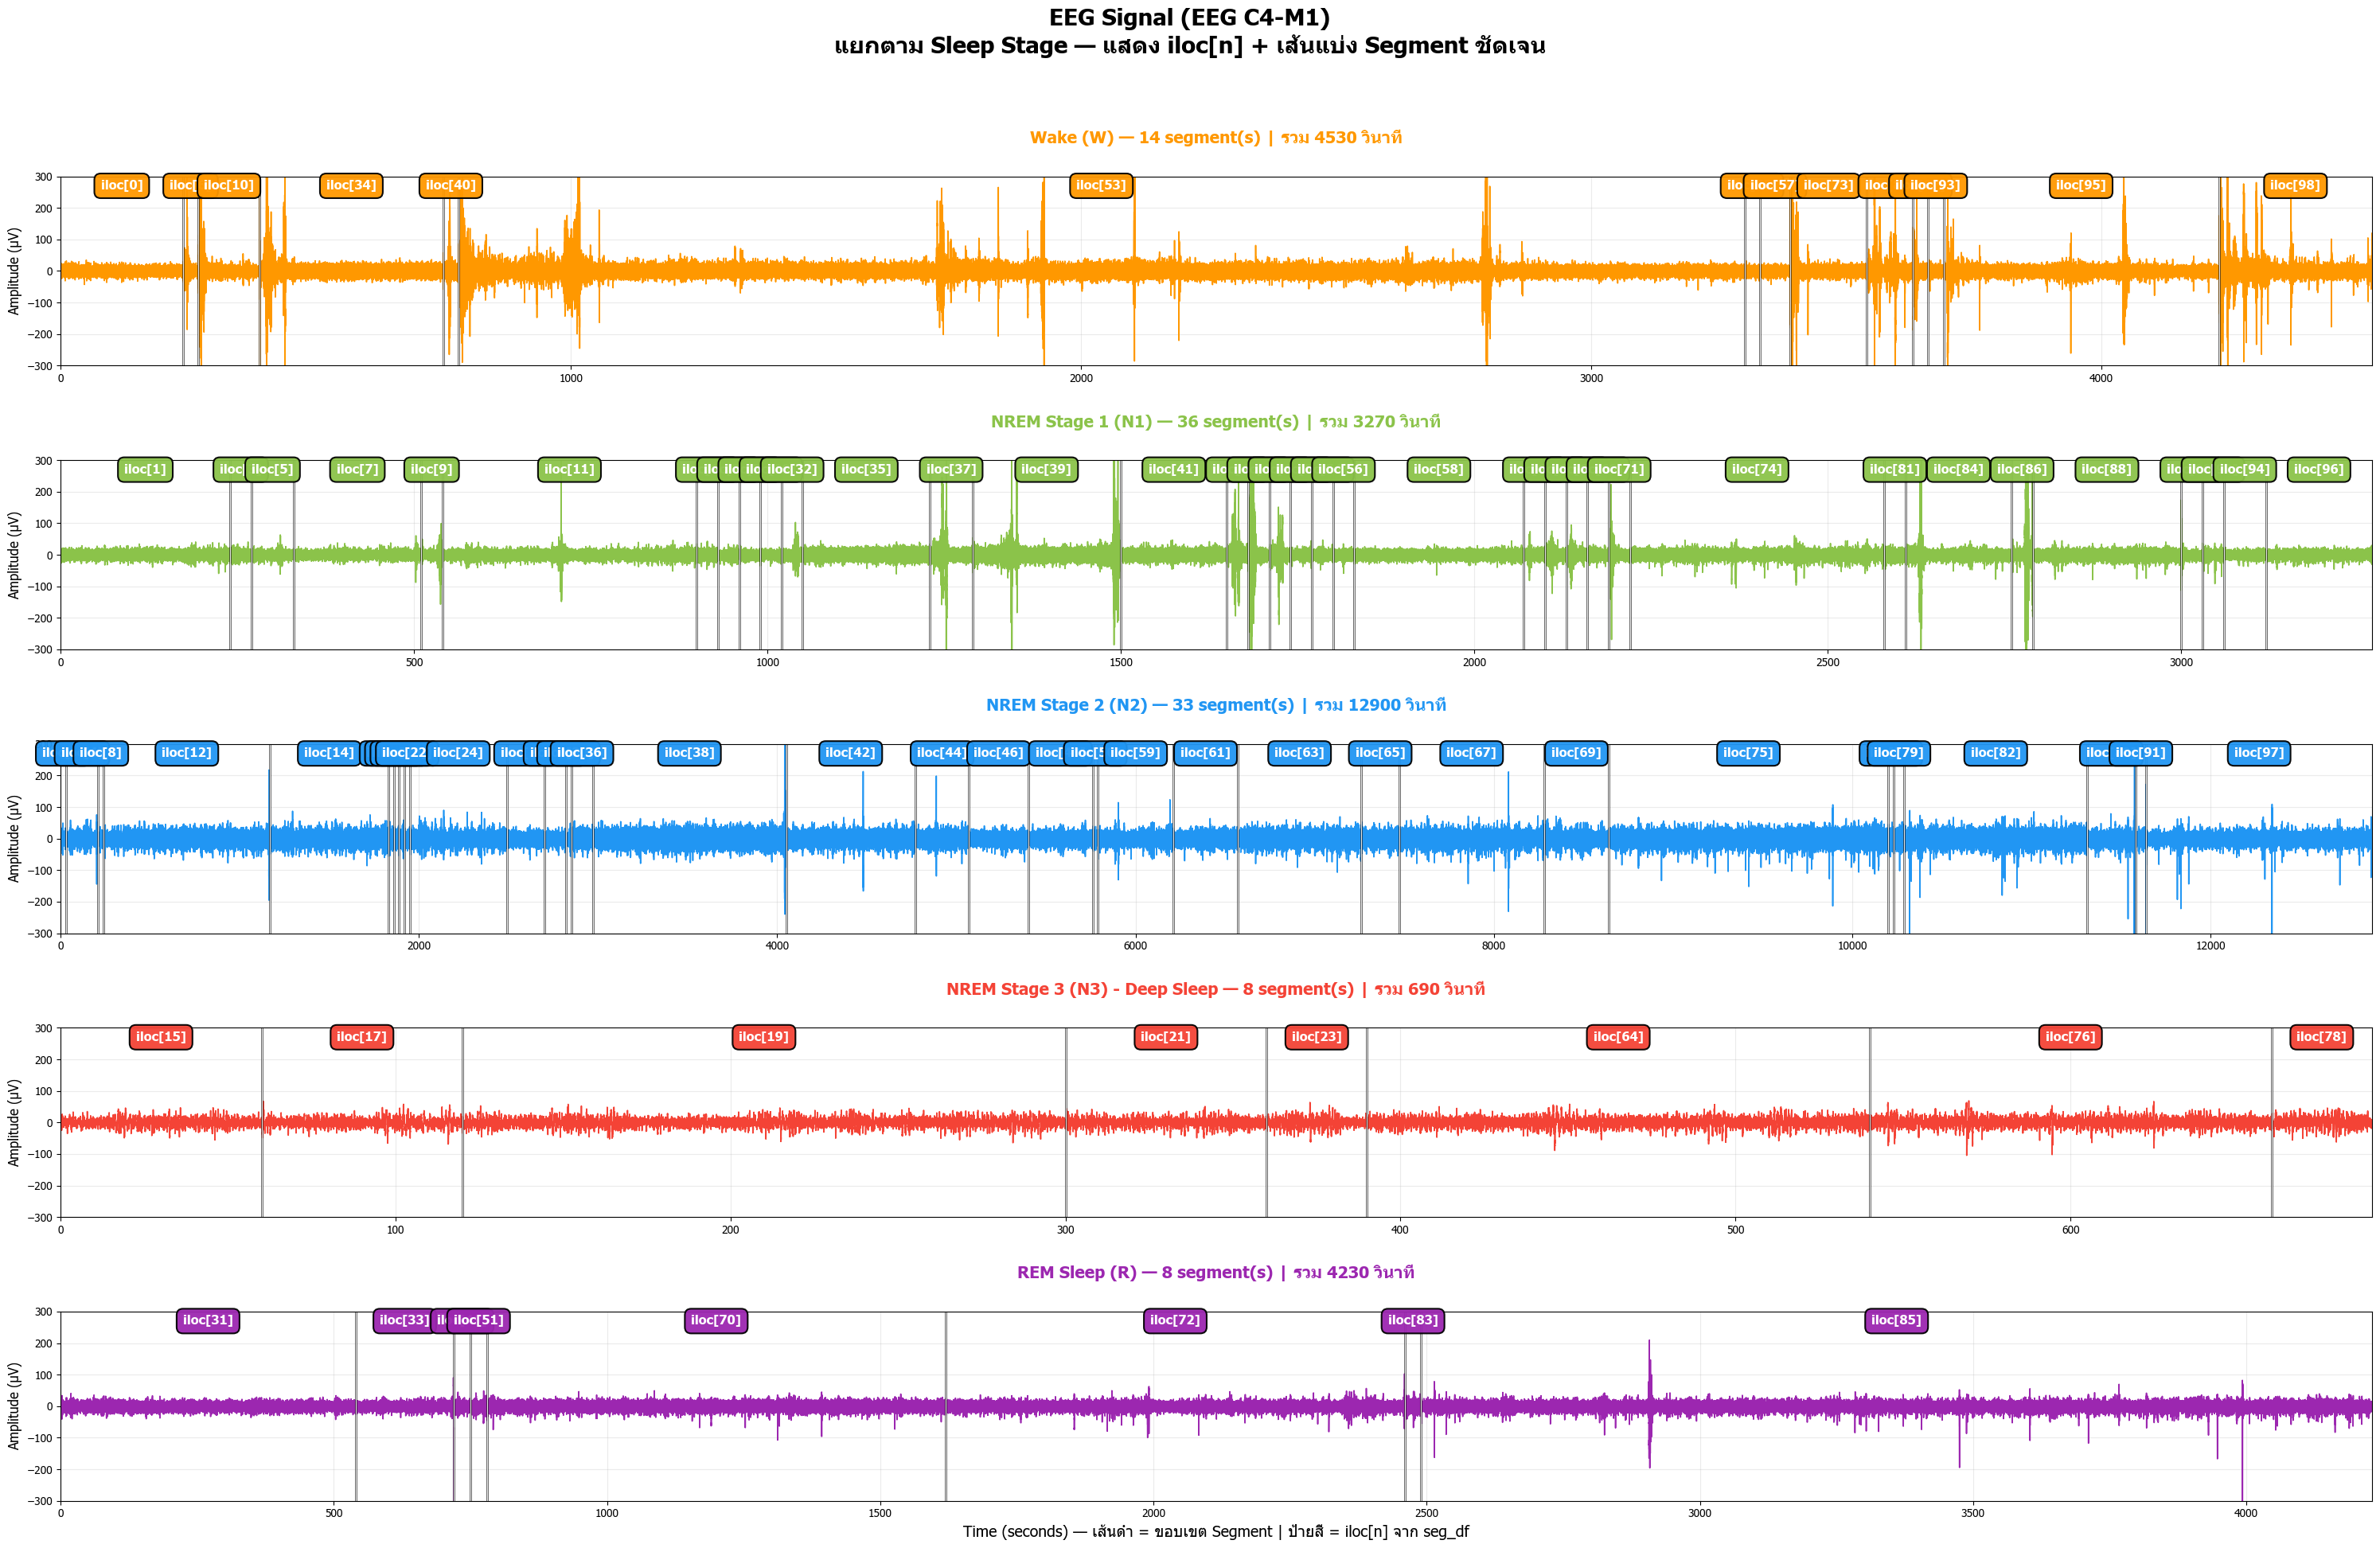

In [27]:
import matplotlib.pyplot as plt
import numpy as np

eeg_channel = 'EEG C4-M1'

stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

plt.rcParams['font.family'] = 'Tahoma'

fig, axes = plt.subplots(5, 1, figsize=(30, 20))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage — แสดง iloc[n] + เส้นแบ่ง Segment ชัดเจน',
             fontsize=21, fontweight='bold', y=0.97)

for idx, (stage_name, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    stage_segments = seg_df[seg_df['Annotation'] == stage_name]
    
    if stage_segments.empty:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes, ha='center', va='center',
                fontsize=16, color='gray')
        ax.set_title(stage_titles[stage_name], fontsize=14, color=color, pad=20)
        ax.set_ylim(-300, 300)
        ax.set_yticks(np.arange(-300, 301, 100))
        ax.set_ylabel('Amplitude (µV)')
        ax.grid(True, alpha=0.25)
        continue

    total_time = 0.0
    segment_boundaries = []  # เก็บตำแหน่งที่ต้องวาดเส้นแบ่ง

    for iloc_idx, row in stage_segments.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal), endpoint=False)

        # วาดสัญญาณ
        ax.plot(time_axis, signal, color=color, linewidth=1.2)

        # ติดป้าย iloc[n]
        mid_time = total_time + duration / 2
        ax.text(mid_time, 270, f'iloc[{iloc_idx}]', fontsize=11.5, fontweight='bold',
                color='white', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.95,
                         edgecolor='black', linewidth=1.5))

        # เก็บตำแหน่งจบของ segment เพื่อวาดเส้นแบ่ง (ยกเว้นอันสุดท้าย)
        if total_time > 0:  # อย่าเพิ่งวาดเส้นตั้งแต่ segment แรก
            segment_boundaries.append(total_time)

        total_time += duration

    # วาดเส้นแบ่งระหว่าง segment ทุกอัน
    for boundary_time in segment_boundaries:
        ax.axvline(x=boundary_time, color='black', linewidth=1.8, alpha=0.8, linestyle='-')
        ax.axvline(x=boundary_time, color='white', linewidth=0.8, alpha=0.9, linestyle='-')  # ขอบขาวให้เด่น

    # ตกแต่งกราฟ
    ax.set_ylim(-300, 300)
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_ylabel('Amplitude (µV)', fontsize=12)
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)

    seg_count = len(stage_segments)
    ax.set_title(f"{stage_titles[stage_name]} — {seg_count} segment(s) | รวม {total_time:.0f} วินาที",
                 fontsize=15, fontweight='bold', color=color, pad=30)

axes[-1].set_xlabel('Time (seconds) — เส้นดำ = ขอบเขต Segment | ป้ายสี = iloc[n] จาก seg_df', 
                    fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(hspace=0.5)
plt.show()

## EEG F4-M1

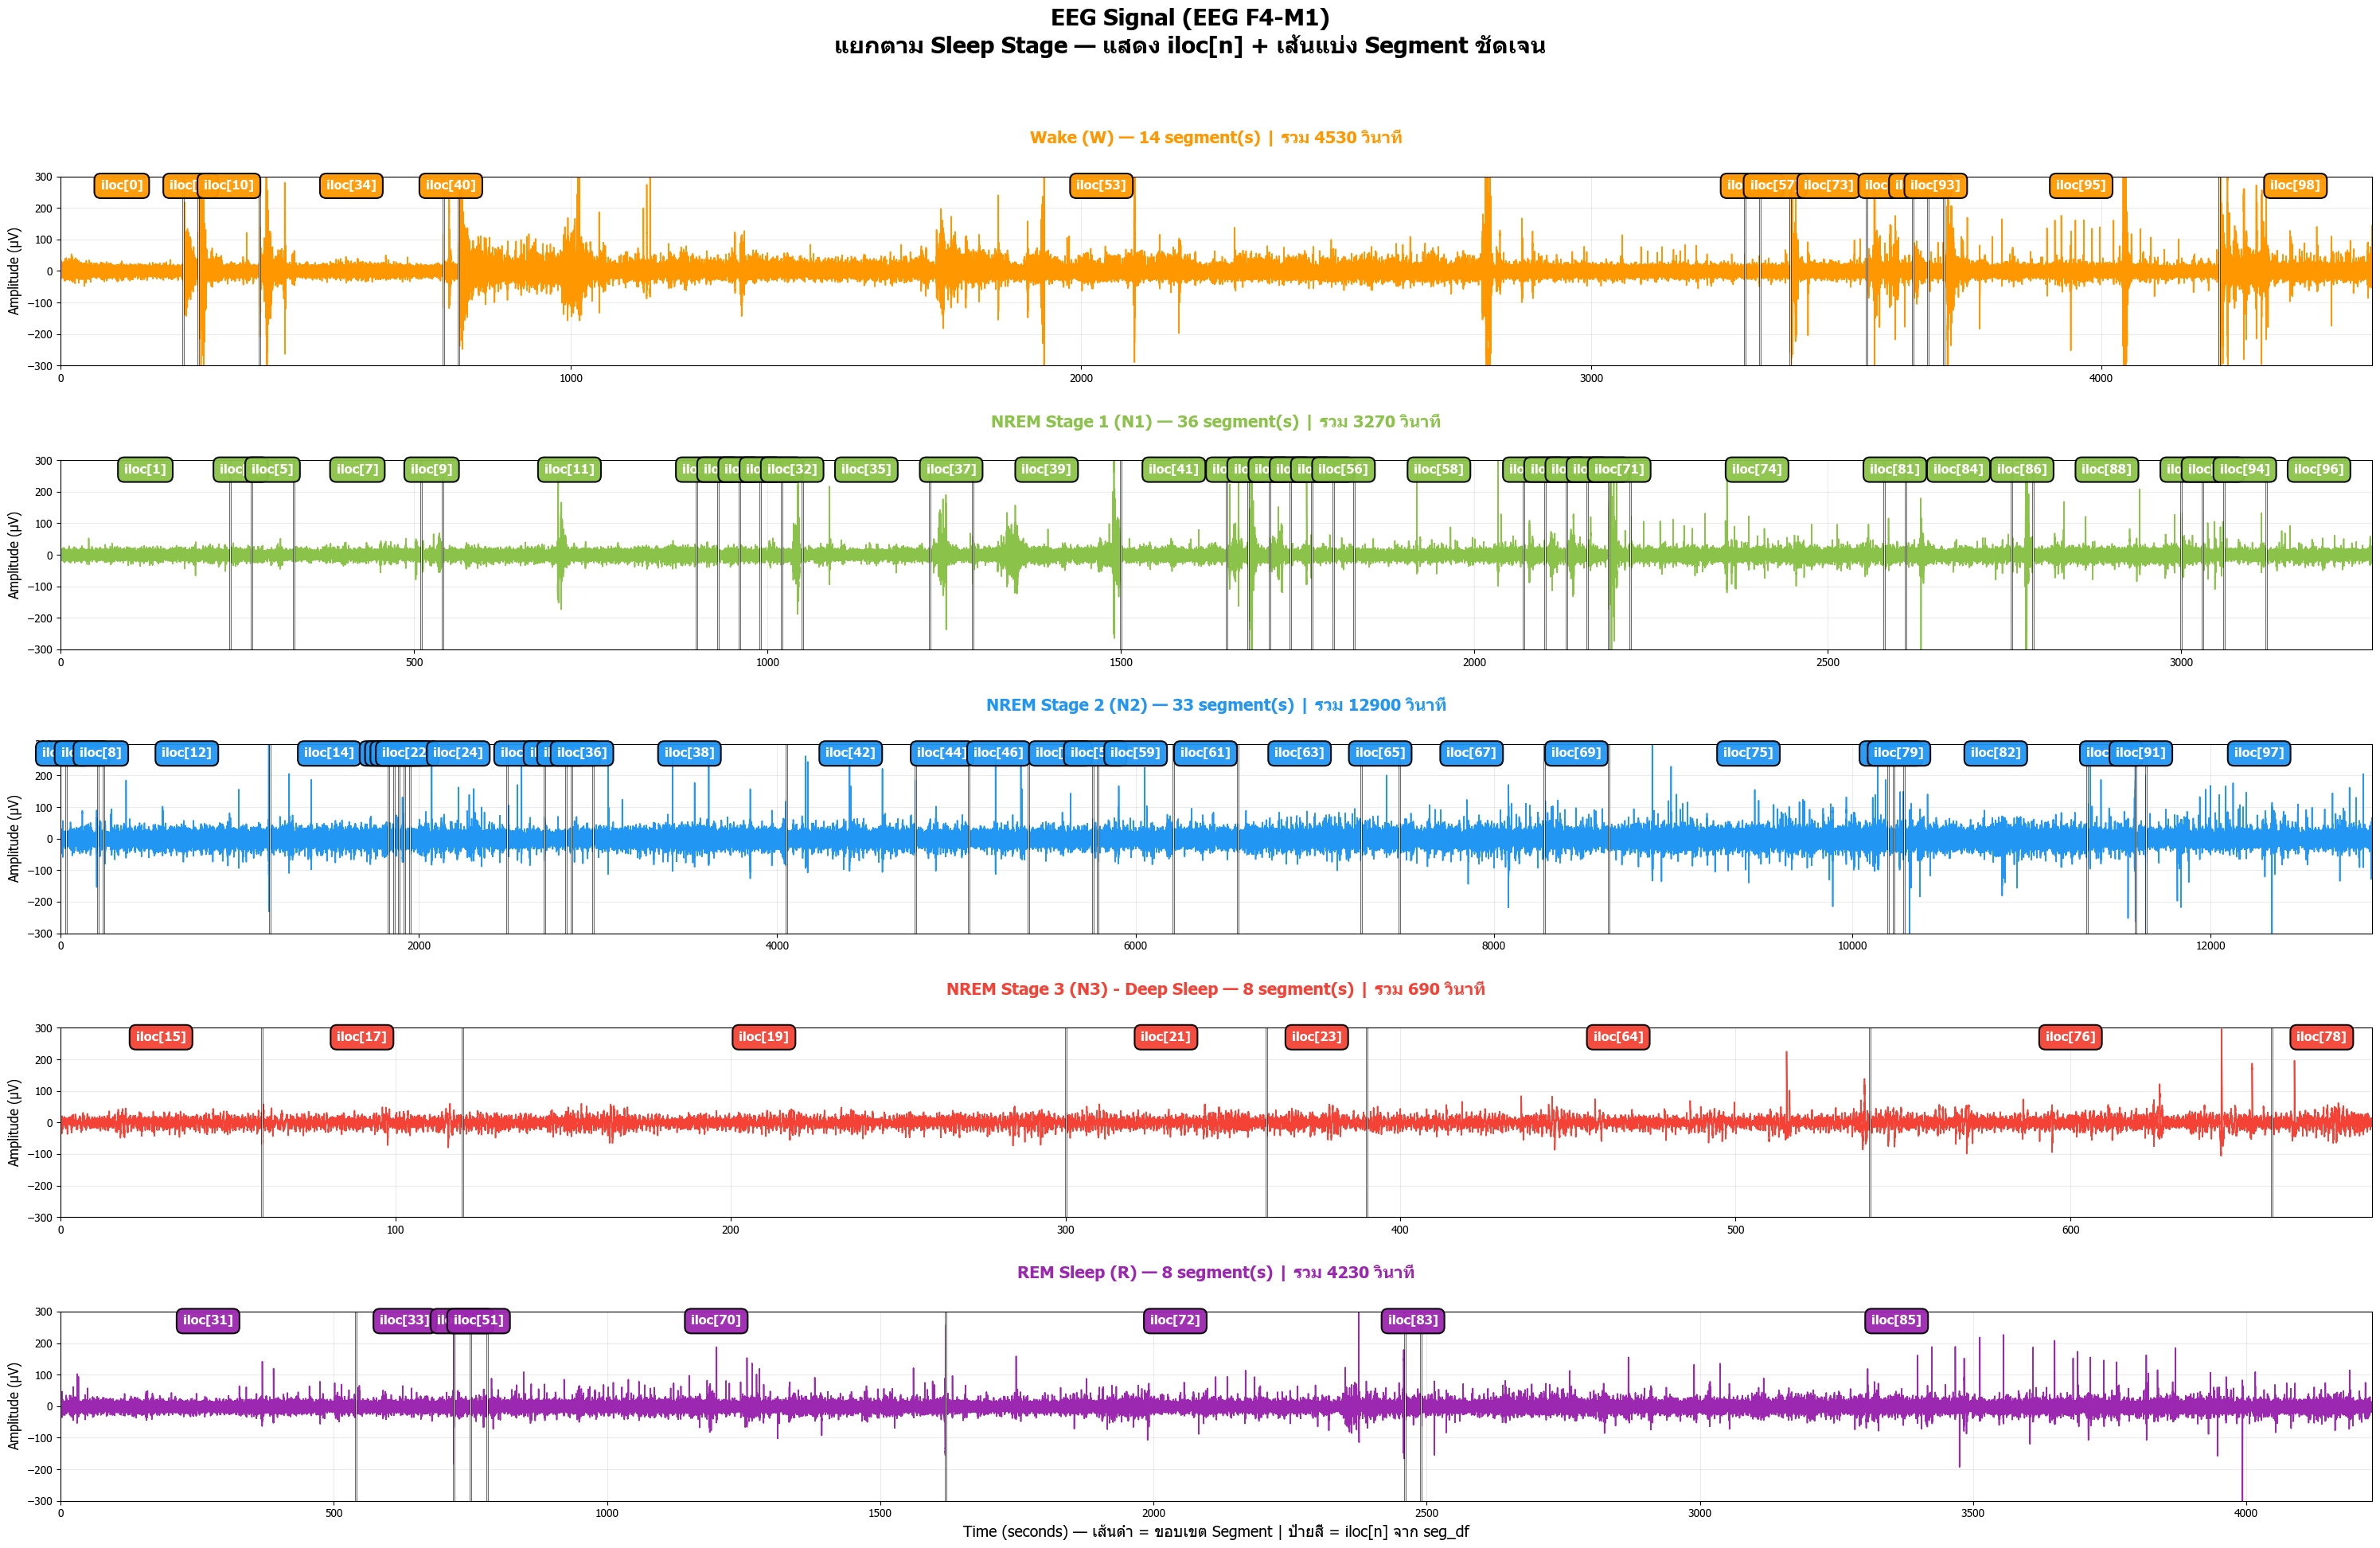

In [28]:
import matplotlib.pyplot as plt
import numpy as np

eeg_channel = 'EEG F4-M1'

stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

plt.rcParams['font.family'] = 'Tahoma'

fig, axes = plt.subplots(5, 1, figsize=(30, 20))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage — แสดง iloc[n] + เส้นแบ่ง Segment ชัดเจน',
             fontsize=21, fontweight='bold', y=0.97)

for idx, (stage_name, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    stage_segments = seg_df[seg_df['Annotation'] == stage_name]
    
    if stage_segments.empty:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes, ha='center', va='center',
                fontsize=16, color='gray')
        ax.set_title(stage_titles[stage_name], fontsize=14, color=color, pad=20)
        ax.set_ylim(-300, 300)
        ax.set_yticks(np.arange(-300, 301, 100))
        ax.set_ylabel('Amplitude (µV)')
        ax.grid(True, alpha=0.25)
        continue

    total_time = 0.0
    segment_boundaries = []  # เก็บตำแหน่งที่ต้องวาดเส้นแบ่ง

    for iloc_idx, row in stage_segments.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal), endpoint=False)

        # วาดสัญญาณ
        ax.plot(time_axis, signal, color=color, linewidth=1.2)

        # ติดป้าย iloc[n]
        mid_time = total_time + duration / 2
        ax.text(mid_time, 270, f'iloc[{iloc_idx}]', fontsize=11.5, fontweight='bold',
                color='white', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.95,
                         edgecolor='black', linewidth=1.5))

        # เก็บตำแหน่งจบของ segment เพื่อวาดเส้นแบ่ง (ยกเว้นอันสุดท้าย)
        if total_time > 0:  # อย่าเพิ่งวาดเส้นตั้งแต่ segment แรก
            segment_boundaries.append(total_time)

        total_time += duration

    # วาดเส้นแบ่งระหว่าง segment ทุกอัน
    for boundary_time in segment_boundaries:
        ax.axvline(x=boundary_time, color='black', linewidth=1.8, alpha=0.8, linestyle='-')
        ax.axvline(x=boundary_time, color='white', linewidth=0.8, alpha=0.9, linestyle='-')  # ขอบขาวให้เด่น

    # ตกแต่งกราฟ
    ax.set_ylim(-300, 300)
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_ylabel('Amplitude (µV)', fontsize=12)
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)

    seg_count = len(stage_segments)
    ax.set_title(f"{stage_titles[stage_name]} — {seg_count} segment(s) | รวม {total_time:.0f} วินาที",
                 fontsize=15, fontweight='bold', color=color, pad=30)

axes[-1].set_xlabel('Time (seconds) — เส้นดำ = ขอบเขต Segment | ป้ายสี = iloc[n] จาก seg_df', 
                    fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(hspace=0.5)
plt.show()

## EEG C3-M2

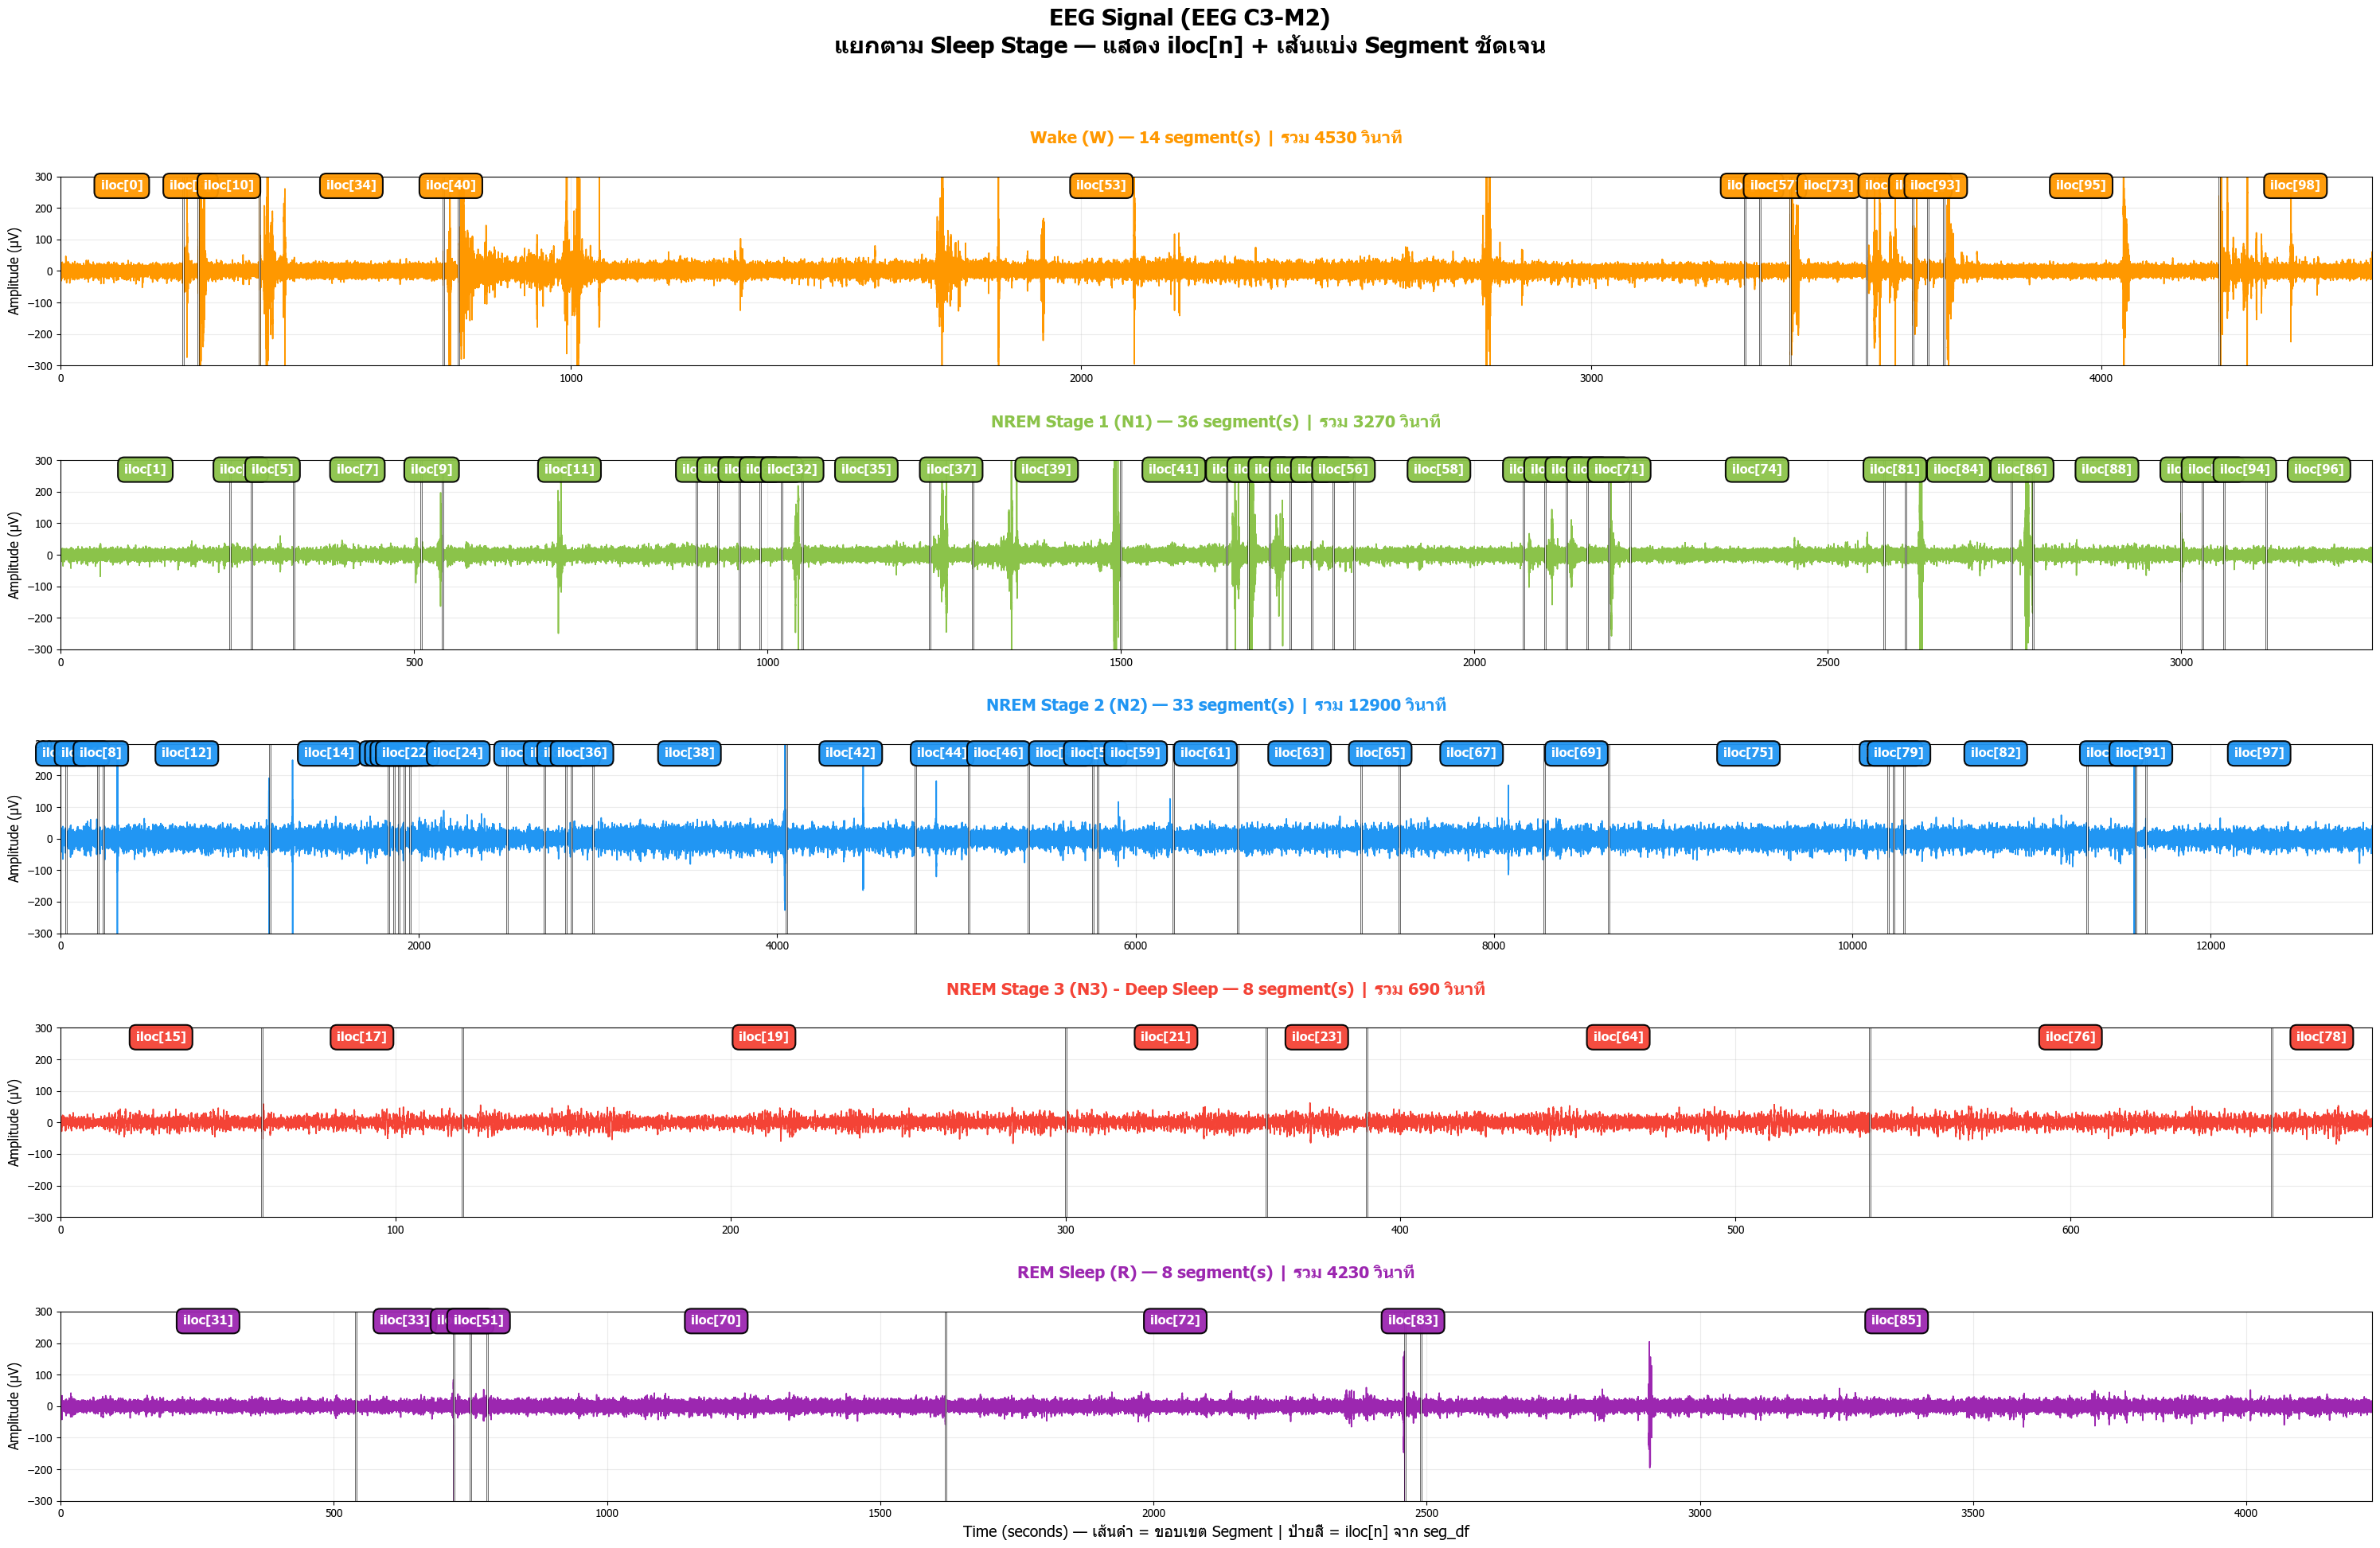

In [29]:
import matplotlib.pyplot as plt
import numpy as np

eeg_channel = 'EEG C3-M2'

stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

plt.rcParams['font.family'] = 'Tahoma'

fig, axes = plt.subplots(5, 1, figsize=(30, 20))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage — แสดง iloc[n] + เส้นแบ่ง Segment ชัดเจน',
             fontsize=21, fontweight='bold', y=0.97)

for idx, (stage_name, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    stage_segments = seg_df[seg_df['Annotation'] == stage_name]
    
    if stage_segments.empty:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes, ha='center', va='center',
                fontsize=16, color='gray')
        ax.set_title(stage_titles[stage_name], fontsize=14, color=color, pad=20)
        ax.set_ylim(-300, 300)
        ax.set_yticks(np.arange(-300, 301, 100))
        ax.set_ylabel('Amplitude (µV)')
        ax.grid(True, alpha=0.25)
        continue

    total_time = 0.0
    segment_boundaries = []  # เก็บตำแหน่งที่ต้องวาดเส้นแบ่ง

    for iloc_idx, row in stage_segments.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal), endpoint=False)

        # วาดสัญญาณ
        ax.plot(time_axis, signal, color=color, linewidth=1.2)

        # ติดป้าย iloc[n]
        mid_time = total_time + duration / 2
        ax.text(mid_time, 270, f'iloc[{iloc_idx}]', fontsize=11.5, fontweight='bold',
                color='white', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.95,
                         edgecolor='black', linewidth=1.5))

        # เก็บตำแหน่งจบของ segment เพื่อวาดเส้นแบ่ง (ยกเว้นอันสุดท้าย)
        if total_time > 0:  # อย่าเพิ่งวาดเส้นตั้งแต่ segment แรก
            segment_boundaries.append(total_time)

        total_time += duration

    # วาดเส้นแบ่งระหว่าง segment ทุกอัน
    for boundary_time in segment_boundaries:
        ax.axvline(x=boundary_time, color='black', linewidth=1.8, alpha=0.8, linestyle='-')
        ax.axvline(x=boundary_time, color='white', linewidth=0.8, alpha=0.9, linestyle='-')  # ขอบขาวให้เด่น

    # ตกแต่งกราฟ
    ax.set_ylim(-300, 300)
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_ylabel('Amplitude (µV)', fontsize=12)
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)

    seg_count = len(stage_segments)
    ax.set_title(f"{stage_titles[stage_name]} — {seg_count} segment(s) | รวม {total_time:.0f} วินาที",
                 fontsize=15, fontweight='bold', color=color, pad=30)

axes[-1].set_xlabel('Time (seconds) — เส้นดำ = ขอบเขต Segment | ป้ายสี = iloc[n] จาก seg_df', 
                    fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(hspace=0.5)
plt.show()

## EEG O2-M1

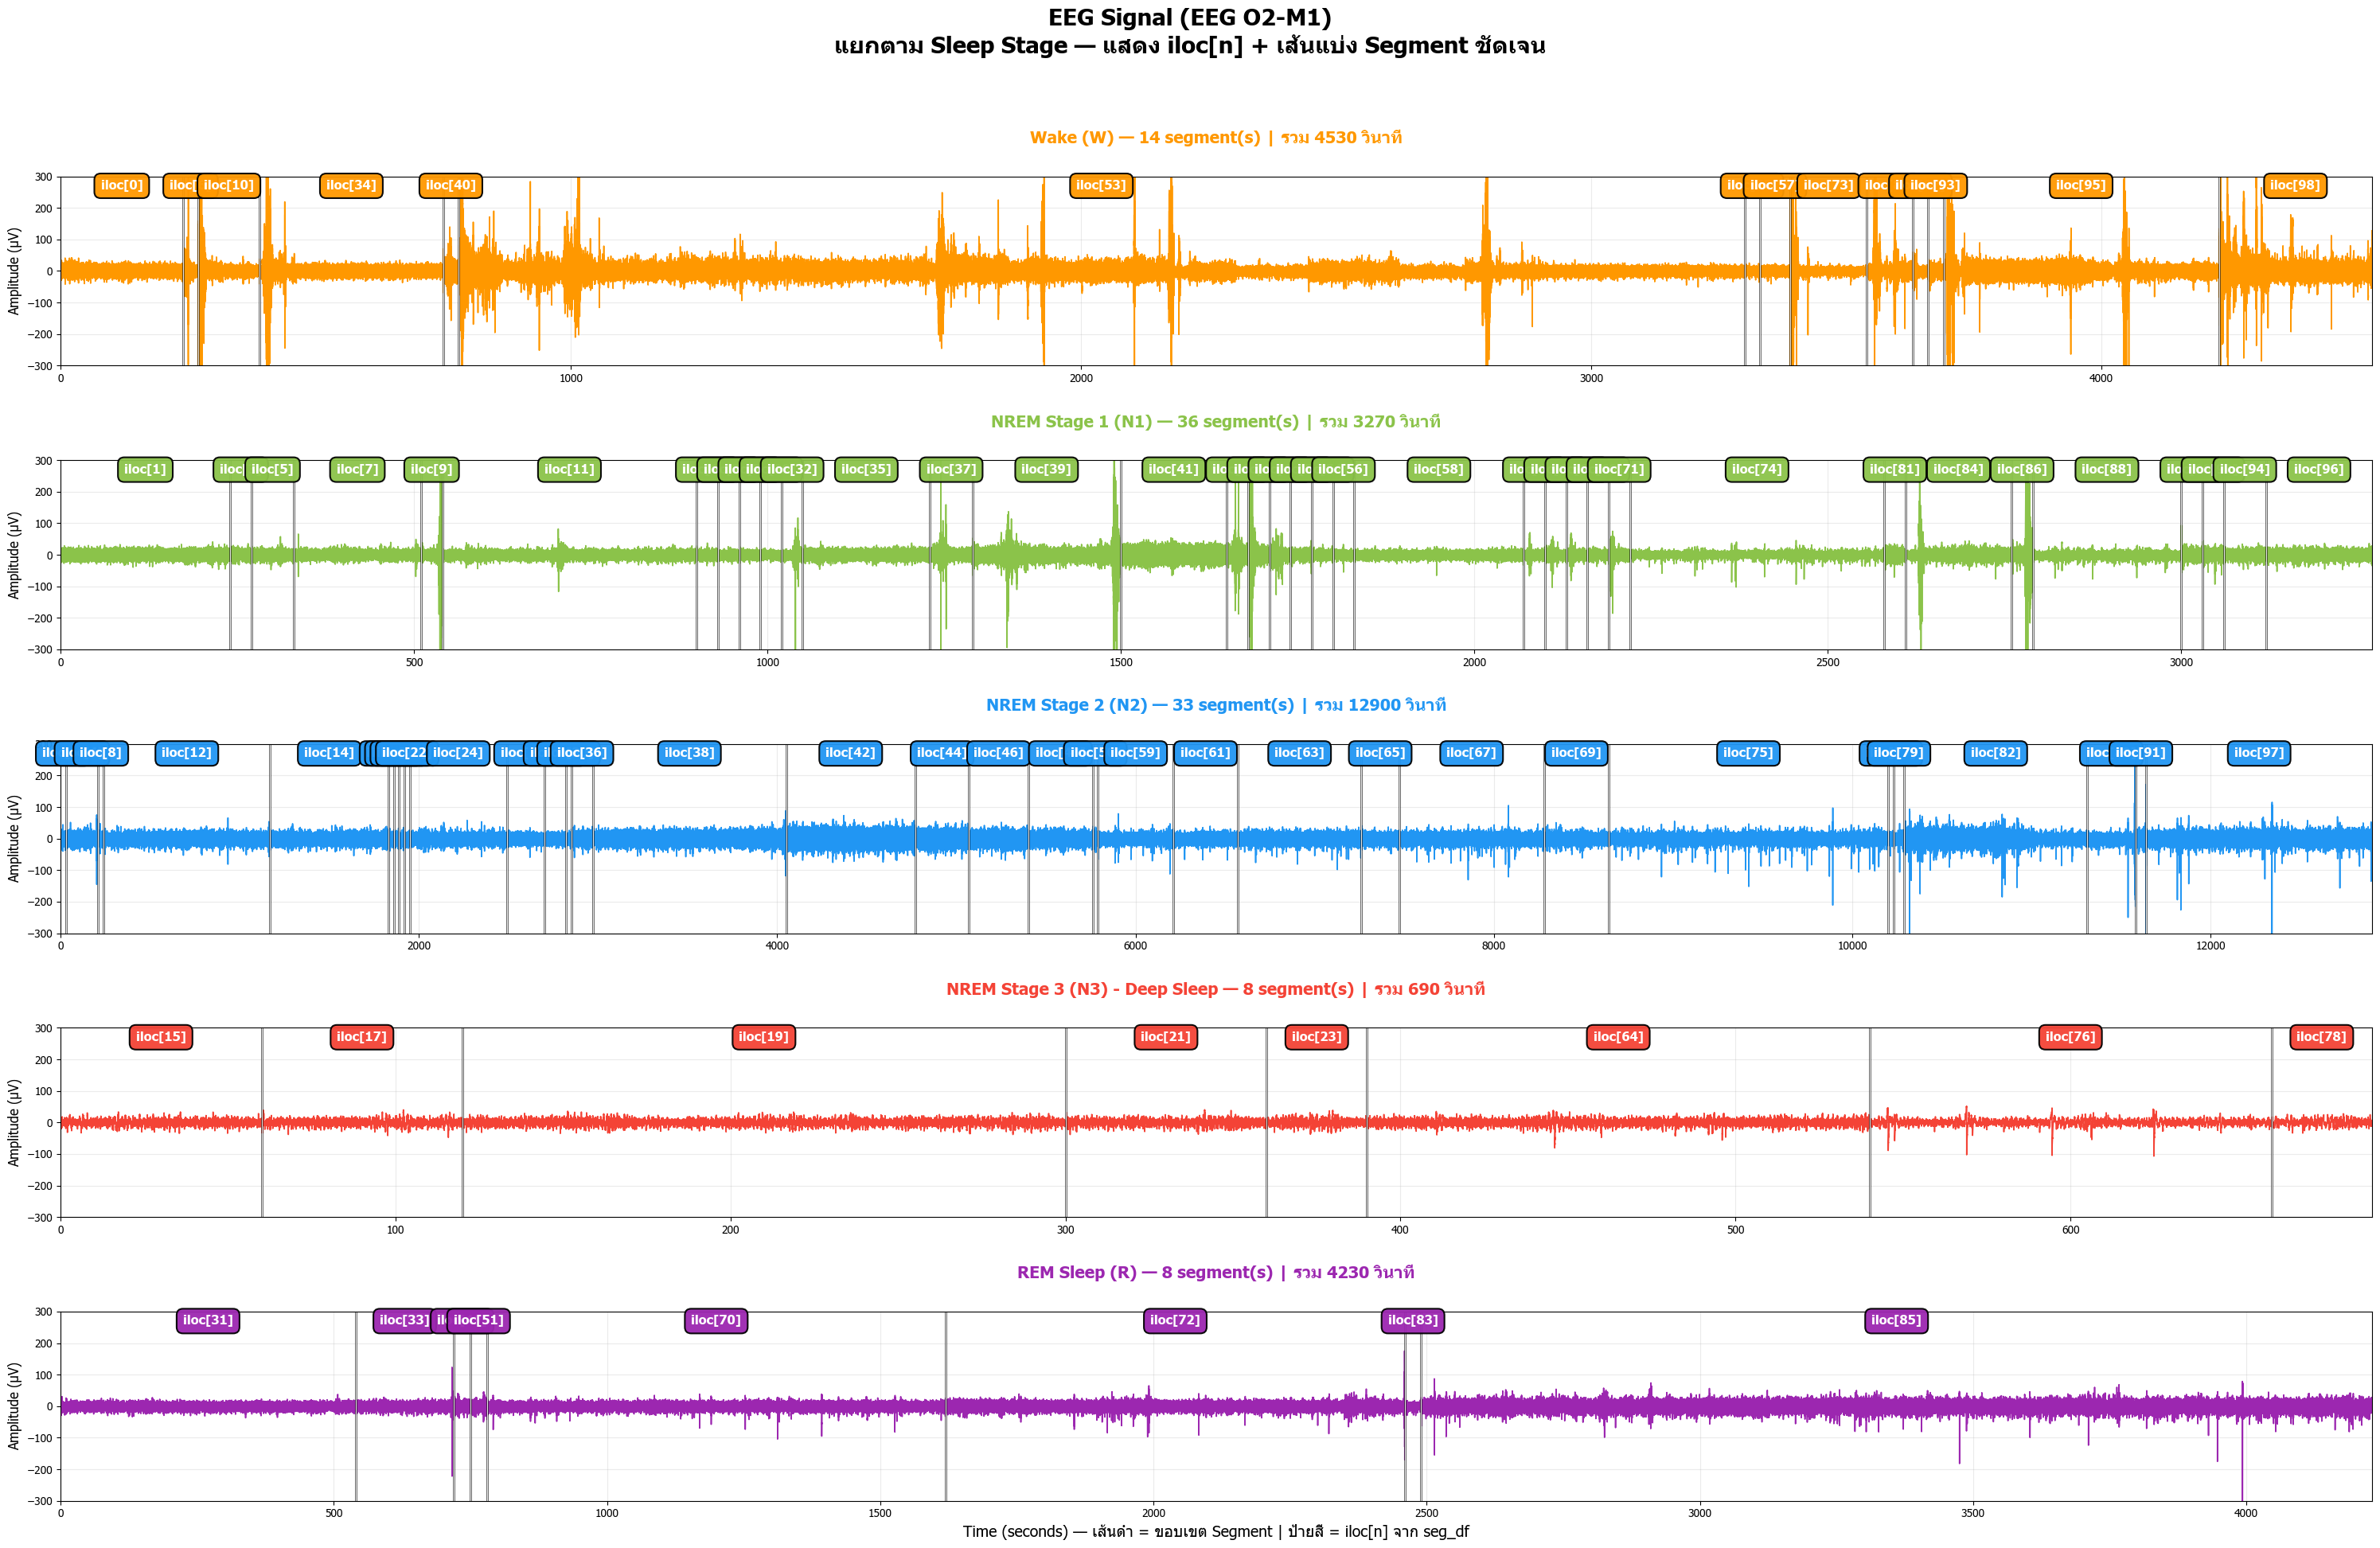

In [30]:
import matplotlib.pyplot as plt
import numpy as np

eeg_channel = 'EEG O2-M1'

stage_colors = {
    ' Sleep stage W': '#FF9800',
    ' Sleep stage N1': '#8BC34A',
    ' Sleep stage N2': '#2196F3',
    ' Sleep stage N3': '#F44336',
    ' Sleep stage R':  '#9C27B0'
}

stage_titles = {
    ' Sleep stage W': 'Wake (W)',
    ' Sleep stage N1': 'NREM Stage 1 (N1)',
    ' Sleep stage N2': 'NREM Stage 2 (N2)',
    ' Sleep stage N3': 'NREM Stage 3 (N3) - Deep Sleep',
    ' Sleep stage R':  'REM Sleep (R)'
}

plt.rcParams['font.family'] = 'Tahoma'

fig, axes = plt.subplots(5, 1, figsize=(30, 20))
fig.suptitle(f'EEG Signal ({eeg_channel})\nแยกตาม Sleep Stage — แสดง iloc[n] + เส้นแบ่ง Segment ชัดเจน',
             fontsize=21, fontweight='bold', y=0.97)

for idx, (stage_name, color) in enumerate(stage_colors.items()):
    ax = axes[idx]
    stage_segments = seg_df[seg_df['Annotation'] == stage_name]
    
    if stage_segments.empty:
        ax.text(0.5, 0.5, 'ไม่มีข้อมูล', transform=ax.transAxes, ha='center', va='center',
                fontsize=16, color='gray')
        ax.set_title(stage_titles[stage_name], fontsize=14, color=color, pad=20)
        ax.set_ylim(-300, 300)
        ax.set_yticks(np.arange(-300, 301, 100))
        ax.set_ylabel('Amplitude (µV)')
        ax.grid(True, alpha=0.25)
        continue

    total_time = 0.0
    segment_boundaries = []  # เก็บตำแหน่งที่ต้องวาดเส้นแบ่ง

    for iloc_idx, row in stage_segments.iterrows():
        start_idx = row['start']
        end_idx = row['end']
        signal = data.loc[start_idx:end_idx-1, eeg_channel].values
        duration = len(signal) / 256.0
        time_axis = np.linspace(total_time, total_time + duration, len(signal), endpoint=False)

        # วาดสัญญาณ
        ax.plot(time_axis, signal, color=color, linewidth=1.2)

        # ติดป้าย iloc[n]
        mid_time = total_time + duration / 2
        ax.text(mid_time, 270, f'iloc[{iloc_idx}]', fontsize=11.5, fontweight='bold',
                color='white', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.5", facecolor=color, alpha=0.95,
                         edgecolor='black', linewidth=1.5))

        # เก็บตำแหน่งจบของ segment เพื่อวาดเส้นแบ่ง (ยกเว้นอันสุดท้าย)
        if total_time > 0:  # อย่าเพิ่งวาดเส้นตั้งแต่ segment แรก
            segment_boundaries.append(total_time)

        total_time += duration

    # วาดเส้นแบ่งระหว่าง segment ทุกอัน
    for boundary_time in segment_boundaries:
        ax.axvline(x=boundary_time, color='black', linewidth=1.8, alpha=0.8, linestyle='-')
        ax.axvline(x=boundary_time, color='white', linewidth=0.8, alpha=0.9, linestyle='-')  # ขอบขาวให้เด่น

    # ตกแต่งกราฟ
    ax.set_ylim(-300, 300)
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_ylabel('Amplitude (µV)', fontsize=12)
    ax.grid(True, alpha=0.25)
    ax.margins(x=0)

    seg_count = len(stage_segments)
    ax.set_title(f"{stage_titles[stage_name]} — {seg_count} segment(s) | รวม {total_time:.0f} วินาที",
                 fontsize=15, fontweight='bold', color=color, pad=30)

axes[-1].set_xlabel('Time (seconds) — เส้นดำ = ขอบเขต Segment | ป้ายสี = iloc[n] จาก seg_df', 
                    fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.subplots_adjust(hspace=0.5)
plt.show()